# Gesture Model Experiments

This notebook compares different machine learning models for gesture classification.


## 1. Load Data


In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
from pathlib import Path


In [2]:
# Get path to gesture_raw data directory
# Note: In Jupyter notebooks, __file__ may not be available
# Adjust path as needed based on your notebook location
notebook_dir = Path.cwd()
ml_dir = notebook_dir.parent
data_dir = ml_dir / 'data' / 'gesture_raw'

print(f"Data directory: {data_dir}")


Data directory: C:\Users\Adhish\motion-edu-app\ml\data\gesture_raw


In [3]:
# Read all CSV files from gesture_raw directory
csv_pattern = str(data_dir / 'gesture_samples_*.csv')
csv_files = glob.glob(csv_pattern)

print(f"Found {len(csv_files)} CSV file(s)")

if not csv_files:
    raise FileNotFoundError(
        f"No gesture sample CSV files found in {data_dir}. "
        "Please run collect_gestures.py first to collect data."
    )


Found 1 CSV file(s)


In [4]:
# Load and concatenate all CSV files
dataframes = []
for csv_file in csv_files:
    print(f"Loading: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    dataframes.append(df)

# Combine all DataFrames
df = pd.concat(dataframes, ignore_index=True)
print(f"\nTotal samples loaded: {len(df)}")


Loading: gesture_samples_20251113_230758.csv

Total samples loaded: 17


In [5]:
# Inspect class balance
# Handle both 'gesture' and 'gesture_label' column names
gesture_col = 'gesture' if 'gesture' in df.columns else 'gesture_label'
if gesture_col not in df.columns:
    raise ValueError("DataFrame must contain a 'gesture' or 'gesture_label' column")

print("Class distribution:")
print(df[gesture_col].value_counts())
print("\nClass balance:")
print(df[gesture_col].value_counts(normalize=True))


Class distribution:
gesture_label
PREV      7
NEXT      5
SELECT    3
REST      2
Name: count, dtype: int64

Class balance:
gesture_label
PREV      0.411765
NEXT      0.294118
SELECT    0.176471
REST      0.117647
Name: proportion, dtype: float64


## 2. Preprocessing


In [6]:
# Drop rows with NaNs
initial_count = len(df)
df = df.dropna()
dropped_count = initial_count - len(df)

print(f"Dropped {dropped_count} rows with NaN values")
print(f"Final dataset size: {len(df)} samples")


Dropped 0 rows with NaN values
Final dataset size: 17 samples


In [7]:
# Separate features (X) and target (y)
# Extract target labels
y = df[gesture_col].copy()

# Extract features (all numeric columns except metadata)
metadata_cols = ['gesture', 'gesture_label', 'sample_index', 'timestamp']
feature_cols = [col for col in df.columns 
                if col not in metadata_cols and pd.api.types.is_numeric_dtype(df[col])]

X = df[feature_cols].copy()

print(f"Features: {len(feature_cols)} columns")
print(f"Labels: {y.nunique()} unique gestures")
if len(feature_cols) > 10:
    print(f"\nFeature columns: {feature_cols[:10]}...")
else:
    print(f"\nFeature columns: {feature_cols}")


Features: 132 columns
Labels: 4 unique gestures

Feature columns: ['landmark_0_x', 'landmark_0_y', 'landmark_0_z', 'landmark_0_visibility', 'landmark_1_x', 'landmark_1_y', 'landmark_1_z', 'landmark_1_visibility', 'landmark_2_x', 'landmark_2_y']...


## 3. Train-Test Split


In [8]:
# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")


Label mapping:
  0: NEXT
  1: PREV
  2: REST
  3: SELECT


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 13 samples
Test set: 4 samples


In [10]:
# Optional: Create validation split from training data
# Uncomment to use validation set
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train,
#     test_size=0.2,
#     random_state=42,
#     stratify=y_train
# )
# print(f"Training set: {len(X_train)} samples")
# print(f"Validation set: {len(X_val)} samples")
# print(f"Test set: {len(X_test)} samples")


## 4. Models to Compare


In [11]:
# Initialize models
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        verbose=1
    ),
    'LogisticRegression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver='lbfgs',  # Good for small-medium datasets
        multi_class='multinomial'
    ),
    'MLPClassifier': MLPClassifier(
        hidden_layer_sizes=(100, 50),  # Shallow neural net: 2 hidden layers
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )
}

print("Models initialized:")
for name in models.keys():
    print(f"  - {name}")


Models initialized:
  - RandomForest
  - LogisticRegression
  - MLPClassifier


## 5. Evaluation


In [12]:
# Store results for comparison
results = {}
fitted_models = {}

# Prepare scaled features for models that need scaling (LogisticRegression, MLPClassifier)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
# Train and evaluate RandomForest
print("=" * 60)
print("RandomForest Classifier")
print("=" * 60)

rf_model = models['RandomForest']
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
results['RandomForest'] = accuracy_rf
fitted_models['RandomForest'] = rf_model

print(f"\nAccuracy: {accuracy_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


RandomForest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.1s



Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


Confusion Matrix:
[[1 0 0]
 [0 2 0]
 [0 0 1]]


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


In [18]:
# Train and evaluate LogisticRegression (with scaling)
print("=" * 60)
print("LogisticRegression Classifier")
print("=" * 60)

lr_model = models['LogisticRegression']
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
results['LogisticRegression'] = accuracy_lr
fitted_models['LogisticRegression'] = lr_model

print(f"\nAccuracy: {accuracy_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr, labels=range(len(label_encoder.classes_))))


LogisticRegression Classifier

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


Confusion Matrix:
[[1 0 0 0]
 [0 2 0 0]
 [0 0 0 0]
 [0 0 0 1]]


C:\Users\Adhish\motion-edu-app\ml\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [19]:
# Train and evaluate MLPClassifier (with scaling)
print("=" * 60)
print("MLPClassifier (Neural Network)")
print("=" * 60)

mlp_model = models['MLPClassifier']
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
results['MLPClassifier'] = accuracy_mlp
fitted_models['MLPClassifier'] = mlp_model

print(f"\nAccuracy: {accuracy_mlp:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp, labels=range(len(label_encoder.classes_))))


MLPClassifier (Neural Network)

Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.83      0.83      0.78         4
weighted avg       0.88      0.75      0.75         4


Confusion Matrix:
[[1 0 0 0]
 [1 1 0 0]
 [0 0 0 0]
 [0 0 0 1]]


In [20]:
# Compare all models
print("=" * 60)
print("Model Comparison")
print("=" * 60)

for model_name, accuracy in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: {accuracy:.4f}")

best_model_name = max(results, key=results.get)
best_model = fitted_models[best_model_name]
best_accuracy = results[best_model_name]

print(f"\nBest model: {best_model_name} with accuracy {best_accuracy:.4f}")


Model Comparison
RandomForest: 1.0000
LogisticRegression: 1.0000
MLPClassifier: 0.7500

Best model: RandomForest with accuracy 1.0000


## 6. Feature Analysis (RandomForest)


In [21]:
# Get feature importances from RandomForest
feature_importances = rf_model.feature_importances_

# Create DataFrame for easier analysis
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print("=" * 60)
print(importance_df.head(20).to_string(index=False))


Top 20 Most Important Features:
               feature  importance
          landmark_8_x    0.026844
         landmark_23_y    0.026398
         landmark_11_x    0.023621
landmark_26_visibility    0.023506
          landmark_0_x    0.021520
         landmark_16_x    0.021085
         landmark_31_x    0.020269
         landmark_10_x    0.019720
         landmark_11_y    0.019529
         landmark_24_y    0.019068
         landmark_20_x    0.018887
         landmark_29_z    0.017888
          landmark_6_x    0.017752
         landmark_12_x    0.017614
          landmark_1_x    0.017078
 landmark_6_visibility    0.017064
          landmark_2_x    0.016162
         landmark_23_x    0.016129
         landmark_14_z    0.015950
          landmark_5_x    0.015727


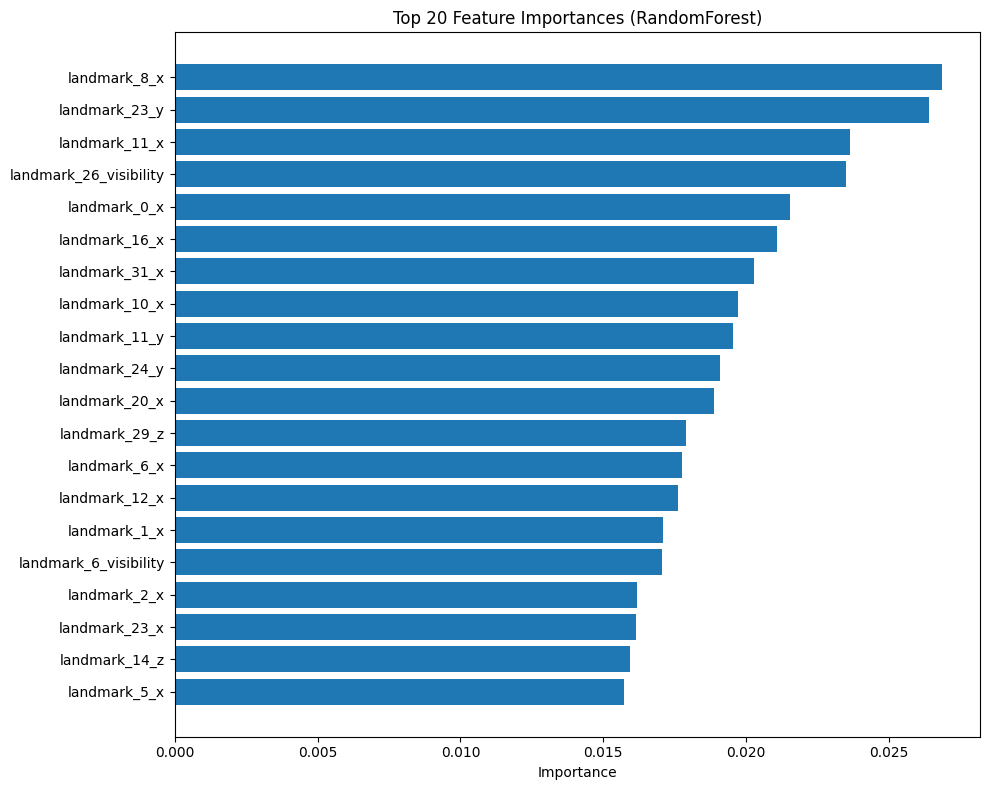

In [22]:
# Visualize top features (optional - requires matplotlib)
# Uncomment to plot
import matplotlib.pyplot as plt
 
top_n = 20
top_features = importance_df.head(top_n)
 
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), top_features['importance'].values)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances (RandomForest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 7. Save Best Model


In [23]:
# Get path to models directory
models_dir = ml_dir / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

print(f"Models directory: {models_dir}")


Models directory: C:\Users\Adhish\motion-edu-app\ml\models


In [24]:
# Save best model
best_model_path = models_dir / 'gesture_best_model.joblib'
encoder_path = models_dir / 'gesture_label_encoder.joblib'

# If best model needs scaling, save scaler too
needs_scaling = best_model_name in ['LogisticRegression', 'MLPClassifier']

if needs_scaling:
    scaler_path = models_dir / 'gesture_scaler.joblib'
    joblib.dump(scaler, scaler_path)
    print(f"Saved scaler to: {scaler_path}")

joblib.dump(best_model, best_model_path)
joblib.dump(label_encoder, encoder_path)

print(f"Saved best model ({best_model_name}) to: {best_model_path}")
print(f"Saved label encoder to: {encoder_path}")


Saved best model (RandomForest) to: C:\Users\Adhish\motion-edu-app\ml\models\gesture_best_model.joblib
Saved label encoder to: C:\Users\Adhish\motion-edu-app\ml\models\gesture_label_encoder.joblib
